## Chap03_고객의 전체 모습을 파악하는 테크닉 

### 전제 조건

* 스포츠 센터에 3종류 (종일 회원, 주간 회원, 야간 회원)의 회원 구분이 있다. 

### 테크닉 21 : 데이터 확인 

* 처음 몇 행을 표시해서 어떤 데이터열이 존재하는지, 각 데이터의 관계성과 같은 데이터의 큰 틀 파악이 중요

In [32]:
import pandas as pd
uselog = pd.read_csv('use_log.csv')
print(len(uselog))
uselog.head()

197428


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [33]:
customer = pd.read_csv('customer_master.csv')
print(len(customer))
customer.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


* name : 이름이 마스킹 되어 있어 이름만으로 개인의 특징을 지을 수 없음

* is_deleted : 2019년 3월 시점에 탈퇴한 유저를 시스테에서 빨리 찾기 위한 컬럼

* 회원 데이터 수 : 4192 명

In [34]:
class_master = pd.read_csv('class_master.csv')
print(len(class_master))
class_master.head()

3


,class,class_name,price
0,C01,0_종일,10500
1,C02,1_주간,7500
2,C03,2_야간,6000


In [35]:
campaign_master = pd.read_csv('campaign_master.csv')
print(len(campaign_master))
campaign_master.head()

3


,campaign_id,campaign_name
0,CA1,2_일반
1,CA2,0_입회비반액할인
2,CA3,1_입회비무료


*  데이터 수가 적은 고객 데이터를 메인으로 진행

* 후반에서는 이용 이력 데이터(uselog)를 중심으로 분석 진행

* 이용 이력 데이터는 무시, 고객 데이터를 수정해서 어떤 고객이 몇 명이었는지와 같은 전체 모습 파악

### 테크닉 22 : 고객 데이터 가공

* 고객 데이터 가공

* 테크닉 21에서 불러온 customer에 회원 구분, class_master와 캠페인 구분 campaign_master를 결합해서 customer_join을 새로 생성 

* 고객 데이터를 중심으로 가로로 결합하는 레프트 조인 

* 조인 전후에 데이터 개수가 변하지 않는 것도 확인

In [36]:
customer_join = pd.merge(customer, class_master, on = "class", how = "left")
customer_join = pd.merge(customer_join, campaign_master, on = "campaign_id", how = "left")
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,0_종일,10500,2_일반
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,2_야간,6000,2_일반


In [37]:
print(len(customer))
print(len(customer_join))

4192
4192


* 조인할 때 키가 없거나 조인이 잘못되면 자동으로 결측치가 들어감.

* 조인 후 결측치 확인 

In [38]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

* end_date에 결측이 있는 이유는 탈퇴하지 않은 회원의 탈퇴일이 공백이기 때문

### 테크닉 23  : 고객 데이터를 집계 

* 집계 항목 생각( 어떤 회원과 어떤 캠페인이 많은지, 언제 입회/탈퇴가 많은지, 남녀 비율은 얼마인지, 탈퇴할 때까지의 기간은 어느 정도인지) 

In [39]:
customer_join.groupby("class_name").count()["customer_id"]

class_name
0_종일    2045
1_주간    1019
2_야간    1128
Name: customer_id, dtype: int64

In [40]:
customer_join.groupby("campaign_name").count()["customer_id"]

campaign_name
0_입회비반액할인     650
1_입회비무료       492
2_일반         3050
Name: customer_id, dtype: int64

In [41]:
customer_join.groupby("gender").count()["customer_id"]

gender
F    1983
M    2209
Name: customer_id, dtype: int64

In [42]:
customer_join.groupby("is_deleted").count()["customer_id"]

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

#### 집계 결과 

* 종일반이 거의 절반을 차지함 (종일반 > 야간 > 주간)

* 캠페인  : 일반회원 > 입회비반액할인 > 입회비무료 (입회 캡페인에 의한 가입 약 20%)

* 남녀 비율 : 남자 회원이 약간 많다.

* 2019년 3월 기준 가입된 회원 : 2842명, 탈퇴 회원 : 1350명 

* start_date가 2018년 4월 1일 이후부터 2019년 3월 31일까지인 가입 인원을 시험 삼아 집계 

In [43]:
customer_join["start_date"] = pd.to_datetime(customer_join["start_date"])
customer_start = customer_join[customer_join["start_date"] > pd.to_datetime("20180401")]
print(len(customer_start))

1361


* 이 기간 가입인원이 1361명

### 테크닉 24 : 최신 고객 데이터 집계 

* 가장 최근 월(2019년 3월)의 고객 데이터 파악 

* 현재 고객 데이터에는 이미 탈퇴한 고객도 포함되어 있기 때문에 월별 집계완느 차이가 있음

* 가장 최근 월의 고객만 추출 : 2019년 3월 31일에 탈퇴한 고객과 재적 중인 고객 추출 

In [44]:
customer_join["end_date"] = pd.to_datetime(customer_join["end_date"])
customer_newer = customer_join.loc[(customer_join["end_date"] >= pd.to_datetime("20190331")) | (customer_join["end_date"].isna())]
print(len(customer_newer))
customer_newer["end_date"].unique()

2953


<DatetimeArray>
['NaT', '2019-03-31 00:00:00']
Length: 2, dtype: datetime64[ns]

#### 출력 결과 

- 데이터 : 2,953 건

- end_date의 유니크는 NaT로, 2019-03-31만 표시된다면 올바르게 추출된 것 

- NaT는 datetime형의 결측치 → 탈퇴하지 않은 고객 

In [45]:
customer_newer.groupby("class_name").count()["customer_id"]

class_name
0_종일    1444
1_주간     696
2_야간     813
Name: customer_id, dtype: int64

In [46]:
customer_newer.groupby("campaign_name").count()["customer_id"]

campaign_name
0_입회비반액할인     311
1_입회비무료       242
2_일반         2400
Name: customer_id, dtype: int64

In [47]:
customer_newer.groupby("gender").count()["customer_id"]

gender
F    1400
M    1553
Name: customer_id, dtype: int64

#### 최근 월 고객 집계 결과

* 캠페인 구분 | 이전 : 일반 회원 79% → 이후 : 일반 회원 81%

* 입회 캠페인은 회원 비율 변화에 영향을 미친다고 추축 가능 

### 테크닉 25 : 이용 이력 데이터 집계 

* 시간적인 요소 도입 

* 월 이용 횟수의 평균값, 중앙값, 최댓값, 최솟값과 정기적 이용 여부를 플래그로 작성해서 고객 데이터에 추가 

* 고객마다 월 이용 횟수를 집계한 데이터 작성 

* 월/고객 이용 횟수 집계 결과 

In [48]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["연월"] = uselog["usedate"].dt.strftime("%y%m")
uselog_months = uselog.groupby(["연월", "customer_id"], as_index = False).count()
uselog_months.rename(columns ={"log_id" : "count"}, inplace = True)
del uselog_months["usedate"]
uselog_months.head()

,연월,customer_id,count
0,1804,AS002855,4
1,1804,AS009013,2
2,1804,AS009373,3
3,1804,AS015315,6
4,1804,AS015739,7


In [49]:
uselog_customer = uselog_months.groupby("customer_id").agg(["mean", "median", "max", "min"])["count"]
uselog_customer = uselog_customer.reset_index(drop = False)
uselog_customer.head()

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


#### 집계 결과 

* 고객 AS002855는 평균값 4.5, 중앙값 5, 최댓값 7, 최솟값 2

### 테크닉 26 : 이용 이력 데이터로부터 정기 이용 플래그 작성

* 고객마다 월/요일별로 집계하고, 최댓값이 4이상인 요일이 하나라도 있는 회원은 플래그 1로 처리 

* 고객별 월/요일 집계 결과 

In [50]:
uselog["weekday"] = uselog["usedate"].dt.weekday # 요일 → 숫자 변환 
uselog_weekday = uselog.groupby(["customer_id", "연월", "weekday"],
                                as_index = False).count()[["customer_id", "연월", "weekday", "log_id"]] # 고객, 연월, 요일별로 log_id 셈
uselog_weekday.rename(columns ={"log_id" : "count"}, inplace = True)
uselog_weekday.head()

,customer_id,연월,weekday,count
0,AS002855,1804,5,4
1,AS002855,1805,2,1
2,AS002855,1805,5,4
3,AS002855,1806,5,5
4,AS002855,1807,1,1


In [51]:
# 고객 단위로 집계하고 최댓값 구하기, 특저 월, 특정 요일에 가장 많이 이용한 횟수
uselog_weekday = uselog_weekday.groupby("customer_id", as_index = False).max()[["customer_id", "count"]]
uselog_weekday["routine_fig"] = 0
# 횟수가 4미만인 경우는 원래의 값인 0을 그대로 두고 4이상인 경우에만 1을 대입
uselog_weekday["routine_fig"] = uselog_weekday["routine_fig"].where(uselog_weekday["count"] < 4, 1)
uselog_weekday.head()

,customer_id,count,routine_fig
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


### 테크닉 27 : 고객 데이터와 이용 이력 데이터를 결합

* 테크닉 25와 테크닉 26에서 작성한 uselog_customer, uselog_weekday를 customer_join과 결합 

In [52]:
customer_join = pd.merge(customer_join, uselog_customer, on = "customer_id", how = "left")
customer_join = pd.merge(customer_join, uselog_weekday[["customer_id", "routine_fig"]], on = "customer_id", how = "left")
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_fig
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1


In [53]:
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
routine_fig         0
dtype: int64

### 테크닉 28 : 회원 기간을 계산 

* 회원 기간은 단순하게 start_date와 end_date의 차이 

* 다만, 2019년 3월까지 탈퇴하지 않은 회원은 end_date에 결측치가 들어 있기 때문에 그 차이를 계산할 수 없음 

* 탈퇴하지 않은 회원은 2019년 4월 30일로 채워서 회원 기간을 계산

* 2019년 3월 31일로 계산할 경우, 실제로 2019년 3월 31일에 탈퇴한 사람(2월 말까지 탈퇴 신청을 한 사람)과 구별 불가능 

In [59]:
from dateutil.relativedelta import relativedelta # relativedelta : 날짜 비교 함수 
customer_join["calc_date"] = customer_join["end_date"]
customer_join["calc_date"] = customer_join["calc_date"].fillna(pd.to_datetime("20190430")) # 결측치에 2019년 4월 30일을 대입
customer_join["membership_period"] = 0
for i in range(len(customer_join)) :
    delta = relativedelta(customer_join["calc_date"].iloc[i], customer_join["start_date"].iloc[i])
    customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months

customer_join.head()

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_join["membership_period"].iloc[i] = delta.years*2 +delta.months
C:\Users\Gong\AppData\Local\Temp\ipykernel_18228\3429235629.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_fig,calc_data,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,5.0,8,2,1,NaT,2019-04-30,17
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,5.083333,5.0,7,3,1,NaT,2019-04-30,17
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.583333,5.0,6,3,1,NaT,2019-04-30,17
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,0_종일,10500,2_일반,4.833333,4.5,7,2,1,NaT,2019-04-30,17
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,2_야간,6000,2_일반,3.916667,4.0,6,1,1,NaT,2019-04-30,17


### 테크닉 29  : 고객 행동의 각종 통계량을 파악 

In [60]:
customer_join[["mean", "median", "max", "min"]].describeribe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


In [63]:
customer_join.groupby("routine_fig")["customer_id"].count()

routine_fig
0     779
1    3413
Name: customer_id, dtype: int64

* 정기적으로 이용하는 회원의 수가 많음

(array([441., 581., 288., 708., 351., 702., 540., 219., 231., 131.]),
 array([ 1. ,  2.6,  4.2,  5.8,  7.4,  9. , 10.6, 12.2, 13.8, 15.4, 17. ]),
 <BarContainer object of 10 artists>)

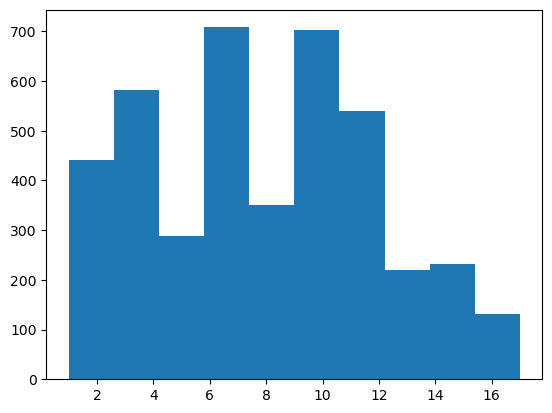

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(customer_join["membership_period"])

### 테크닉 30 : 탈퇴 회원과 지속 회원의 차이 파악 

* 테크닉 23에서 집계한 탈퇴 회원은 1,350명 지속 회원은 2,840명

* 탈퇴 회원과 집계 회원 비교 

In [68]:
customer_end = customer_join.loc[customer_join["is_deleted"] == 1]
customer_end.describe()

,start_date,end_date,is_deleted,price,mean,median,max,min,routine_fig,calc_data,calc_date,membership_period
count,1350,1350,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350,1350,1350.000000
mean,2018-01-20 10:45:20,2018-10-17 16:23:28,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,0.456296,2018-10-17 16:23:28,2018-10-17 16:23:28,6.078519
min,2016-05-01 00:00:00,2018-04-30 00:00:00,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,2018-04-30 00:00:00,2018-04-30 00:00:00,1.000000
25%,2017-10-01 00:00:00,2018-06-30 00:00:00,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,0.000000,2018-06-30 00:00:00,2018-06-30 00:00:00,3.000000
50%,2018-03-01 00:00:00,2018-10-31 00:00:00,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,0.000000,2018-10-31 00:00:00,2018-10-31 00:00:00,6.000000
75%,2018-06-03 00:00:00,2019-01-31 00:00:00,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,1.000000,2019-01-31 00:00:00,2019-01-31 00:00:00,9.000000
max,2019-02-11 00:00:00,2019-03-31 00:00:00,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,1.000000,2019-03-31 00:00:00,2019-03-31 00:00:00,13.000000
std,NaN,NaN,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,0.498271,NaN,NaN,3.223532


In [69]:
customer_stay = customer_join.loc[customer_join["is_deleted"] == 0]
customer_stay.describe()

,start_date,end_date,is_deleted,price,mean,median,max,min,routine_fig,calc_data,calc_date,membership_period
count,2842,0,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,0,2842,2842.000000
mean,2017-04-03 22:42:28.627726848,NaT,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,0.984166,NaT,2019-04-30 00:00:00,8.667840
min,2015-05-01 00:00:00,NaT,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,0.000000,NaT,2019-04-30 00:00:00,1.000000
25%,2016-05-01 00:00:00,NaT,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,1.000000,NaT,2019-04-30 00:00:00,6.000000
50%,2017-04-01 00:00:00,NaT,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,1.000000,NaT,2019-04-30 00:00:00,9.000000
75%,2018-04-05 00:00:00,NaT,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,1.000000,NaT,2019-04-30 00:00:00,12.000000
max,2019-03-15 00:00:00,NaT,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,1.000000,NaT,2019-04-30 00:00:00,17.000000
std,NaN,NaN,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.124855,NaN,NaN,4.003362


In [70]:
customer_join.to_csv('customer_join.csv', index = False)